In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from scipy import spatial
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split,learning_curve,ShuffleSplit,cross_validate,StratifiedKFold,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns

C:\Users\fahan\Program files\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
webis_df = pd.read_csv('webis_df.tsv',sep="\t")
print(webis_df.shape)
print(webis_df['label'].isnull().sum())
webis_df.head()

(7859, 5)
0


,original_file,paraphrase_file,label,original_text,paraphrase_text
0,1-original.txt,1-paraphrase.txt,Yes,m comte would not advise so irrational a proce...,even m comte would spurn such irrational reaso...
1,2-original.txt,2-paraphrase.txt,Yes,without enumerating all the modern authors who...,just without specifying the current writers wh...
2,3-original.txt,3-paraphrase.txt,Yes,therefore a person should search his actions a...,as such a person should analyze what he did an...
3,4-original.txt,4-paraphrase.txt,Yes,i have heard many accounts of him said emily ...,emily said i have heard many different things ...
4,5-original.txt,5-paraphrase.txt,No,i have heard many accounts of him said emily ...,i have heard many accounts of him said emily ...


In [ ]:
def get_vocab_and_counts(answer_text, source_text, n):
    """
    Using CountVectorizer, create a vocabulary based on the answer and source text. 
    Then, count the number of occurences of each ngram in the vocabulary for answer
    and source text.
    
    Args:
        answer_text (string): answer text
        source_test (string): source text to be compared with answer text
        n: the n in n-gram
    
    Returns:
        vocab (dict): generated by fitting the CountVectorizer to answer and source text
        counts.toarray() (2D numpy array): the ngram counts for answer and source text
    """
    counts_ngram = CountVectorizer(analyzer='word', ngram_range=(n,n))
    vocab = counts_ngram.fit([answer_text, source_text]).vocabulary_
    counts = counts_ngram.fit_transform([answer_text, source_text])
    
    return vocab, counts.toarray()

In [ ]:
def calculate_containment(df, n):
    containment = []
    for index, row in df.iterrows():
        vocab, ngram_counts = get_vocab_and_counts(row['paraphrase_text'], row['original_text'], n)
        intersection_list = np.amin(ngram_counts, axis = 0)
        intersection = np.sum(intersection_list)
        count_ngram_P = np.sum(ngram_counts[0])
        if(count_ngram_P == 0):
            print(index)
        containment.append(intersection/count_ngram_P)
    return(np.array(containment).reshape(-1,1))

In [ ]:
def Sumo_metric(answer_text,source_text,k):
    [vocab,word_count] = get_vocab_and_counts(answer_text, source_text, n=1)
    answer_text_count = np.sum(word_count[0])
    source_text_count = np.sum(word_count[1])
    intersection_list = np.amin(word_count, axis = 0)
    intersection = np.sum(intersection_list)
    sumo_metric = (0.5*np.log2(answer_text_count/intersection))+(0.5*np.log2(source_text_count/intersection))
    if(sumo_metric < 1):
        sumo_metric = sumo_metric
    else:
        sumo_metric = np.exp(-k*sumo_metric)
    return(sumo_metric)

In [ ]:
def calculate_sumo(df):
    sumo = []
    for index,row in tqdm(df.iterrows()):
        sumo.append(Sumo_metric(row['paraphrase_text'],row['original_text'],k=3))
    return(sumo)

In [ ]:
def blue_score(answer_text,source_text,n):
    blue_score = 0
    for i in range(1,n+1):
        [vocab,word_count] = get_vocab_and_counts(answer_text, source_text,i)
        answer_text_len = len(answer_text.split())
        source_text_len = len(source_text.split())
        answer_text_count = np.sum(word_count[0])
        source_text_count = np.sum(word_count[1])
        intersection_list = np.amin(word_count, axis = 0)
        intersection = np.sum(intersection_list)
        if(answer_text_len < source_text_len):
            count_ngram = np.max(answer_text_count)
        else:
            count_ngram = np.max(source_text_count)
        
        if(intersection>0):
            blue_score+=np.log2(intersection/count_ngram)
    
    blue_score = (1/n)*np.exp(blue_score) 
    return(blue_score)

In [ ]:
def calculate_blue(df,n):
    blue = []
    for index,row in tqdm(df.iterrows()):
        blue.append(blue_score(row['paraphrase_text'],row['original_text'],n))
    return(blue)

In [ ]:
def calculate_bert_sim(df):
    bert_model = SentenceTransformer('all-mpnet-base-v2')
    bert_sim = [1-spatial.distance.cosine(bert_model.encode(df['paraphrase_text'].iloc[i]), bert_model.encode(df['original_text'].iloc[i])) for i in tqdm(range(df.shape[0]))]
    return(bert_sim)

In [ ]:
max_n_gram = 7
n_gram_range = range(1,max_n_gram+1)
webis_df['paraphrase_word_count'] = webis_df['paraphrase_text'].progress_apply(lambda x: len(x.split()))
webis_df = webis_df[webis_df['paraphrase_word_count']>max_n_gram]

100%|███████████████████████████████████████████████████████████████████████████| 7859/7859 [00:00<00:00, 25224.68it/s]


In [ ]:
webis_df.to_csv("webis_preprocessed.csv",index=False)

In [ ]:
#create containment features
c_feature_list = []
containment_features = []
for i in tqdm(n_gram_range):
    c_feature_list.append(f'c_{i}')
    containment = calculate_containment(webis_df,i)
    containment_features.append(containment)
features_df = pd.DataFrame(np.squeeze(containment_features).T, columns=c_feature_list)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [05:38<00:00, 48.41s/it]


In [ ]:
features_df.shape, webis_df.shape

((7456, 7), (7456, 6))

In [ ]:
features_df['sumo'] = calculate_sumo(webis_df)

7456it [00:51, 145.57it/s]


In [ ]:
features_df['blue_score'] = calculate_blue(webis_df,n=4)

7456it [04:09, 29.88it/s]


In [ ]:
features_df['bert_sim'] = calculate_bert_sim(webis_df)

100%|████████████████████████████████████████████████████████████████████████████| 7456/7456 [3:21:54<00:00,  1.62s/it]


In [ ]:
features_df.to_csv('webis_feature_df_1.csv', index=False)

In [ ]:
webis_df.reset_index(inplace=True)
features_df['label'] = webis_df['label']
features_df['label'] = np.where(features_df['label']=='Yes',1,0)

In [ ]:
X=features_df.iloc[:,:-1]
y=features_df.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,random_state=42)

In [ ]:
X_test.shape[0]/features_df.shape[0]

0.25

In [ ]:
features_df.columns

Index(['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7', 'sumo', 'blue_score',
       'bert_sim', 'label'],
      dtype='object')

# Univariate Analysis

C:\Users\fahan\Program files\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\fahan\Program files\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\fahan\Program files\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` 

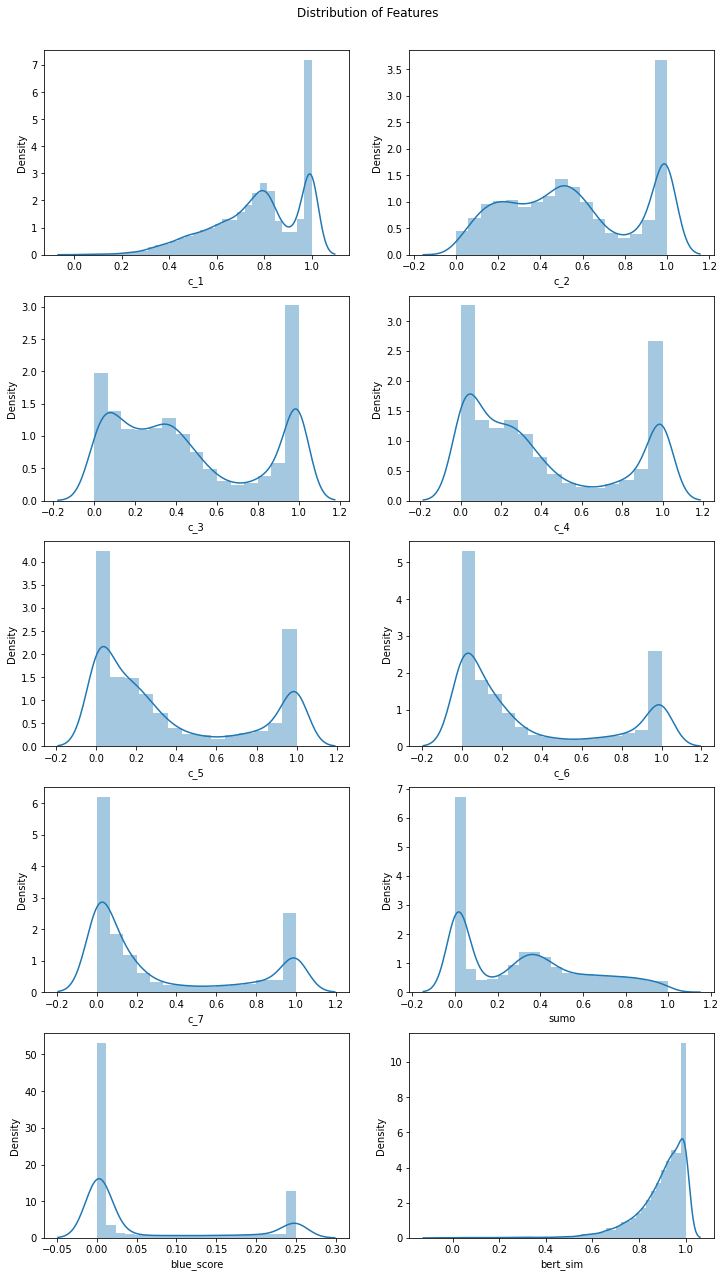

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(12, 20))
fig.suptitle('Distribution of Features')
sns.distplot(ax=axes[0,0], a=features_df['c_1'])
sns.distplot(ax=axes[0,1], a=features_df['c_2'])
sns.distplot(ax=axes[1,0], a=features_df['c_3'])
sns.distplot(ax=axes[1,1], a=features_df['c_4'])
sns.distplot(ax=axes[2,0], a=features_df['c_5'])
sns.distplot(ax=axes[2,1], a=features_df['c_6'])
sns.distplot(ax=axes[3,0], a=features_df['c_7'])
sns.distplot(ax=axes[3,1], a=features_df['sumo'])
sns.distplot(ax=axes[4,0], a=features_df['blue_score'])
sns.distplot(ax=axes[4,1], a=features_df['bert_sim'])
fig.subplots_adjust(top=0.95)
plt.show()
fig.savefig('feature_distribution.png')

In [ ]:
features_df.drop(columns='label').describe()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,sumo,blue_score,bert_sim
count,7456.000000,7456.000000,7456.000000,7456.000000,7456.000000,7456.000000,7456.000000,7456.000000,7.456000e+03,7456.000000
mean,0.766433,0.558575,0.460484,0.403477,0.364885,0.337006,0.316187,0.320013,6.252713e-02,0.891250
std,0.191796,0.307597,0.348464,0.366184,0.375859,0.381615,0.385019,0.293993,9.686919e-02,0.122058
min,0.029046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.097597e-11,-0.064483
25%,0.643784,0.301218,0.153846,0.082545,0.041667,0.019858,0.001418,0.025962,1.440705e-04,0.848382
50%,0.786637,0.525000,0.375000,0.274872,0.201587,0.149589,0.110301,0.304607,3.126964e-03,0.924192
75%,0.952756,0.891114,0.839394,0.794263,0.752587,0.717125,0.682200,0.520258,1.177852e-01,0.974983
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999897,2.500000e-01,1.000000


## Bivariate Analysis

In [ ]:
corr_matrix = X_train.corr().abs().round(2)
corr_matrix

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,sumo,blue_score,bert_sim
c_1,1.00,0.94,0.90,0.87,0.84,0.82,0.80,0.29,0.71,0.66
c_2,0.94,1.00,0.99,0.97,0.95,0.93,0.91,0.44,0.83,0.60
c_3,0.90,0.99,1.00,0.99,0.98,0.97,0.96,0.49,0.89,0.56
c_4,0.87,0.97,0.99,1.00,1.00,0.99,0.98,0.52,0.92,0.53
c_5,0.84,0.95,0.98,1.00,1.00,1.00,0.99,0.54,0.95,0.51
c_6,0.82,0.93,0.97,0.99,1.00,1.00,1.00,0.54,0.96,0.50
c_7,0.80,0.91,0.96,0.98,0.99,1.00,1.00,0.54,0.97,0.48
sumo,0.29,0.44,0.49,0.52,0.54,0.54,0.54,1.00,0.53,0.13
blue_score,0.71,0.83,0.89,0.92,0.95,0.96,0.97,0.53,1.00,0.42
bert_sim,0.66,0.60,0.56,0.53,0.51,0.50,0.48,0.13,0.42,1.00


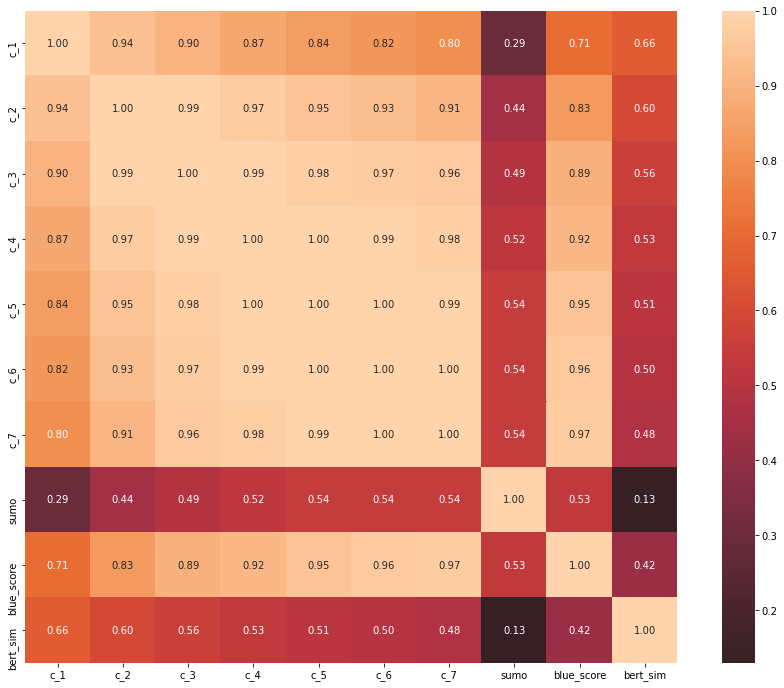

In [ ]:
plt.figure(figsize=(16,12))
corr_plot = sns.heatmap(corr_matrix, center=0, annot=True, 
                fmt='.2f', square=True)
corr_plot_fig = corr_plot.get_figure()
corr_plot_fig.savefig('correlation_plot.png')

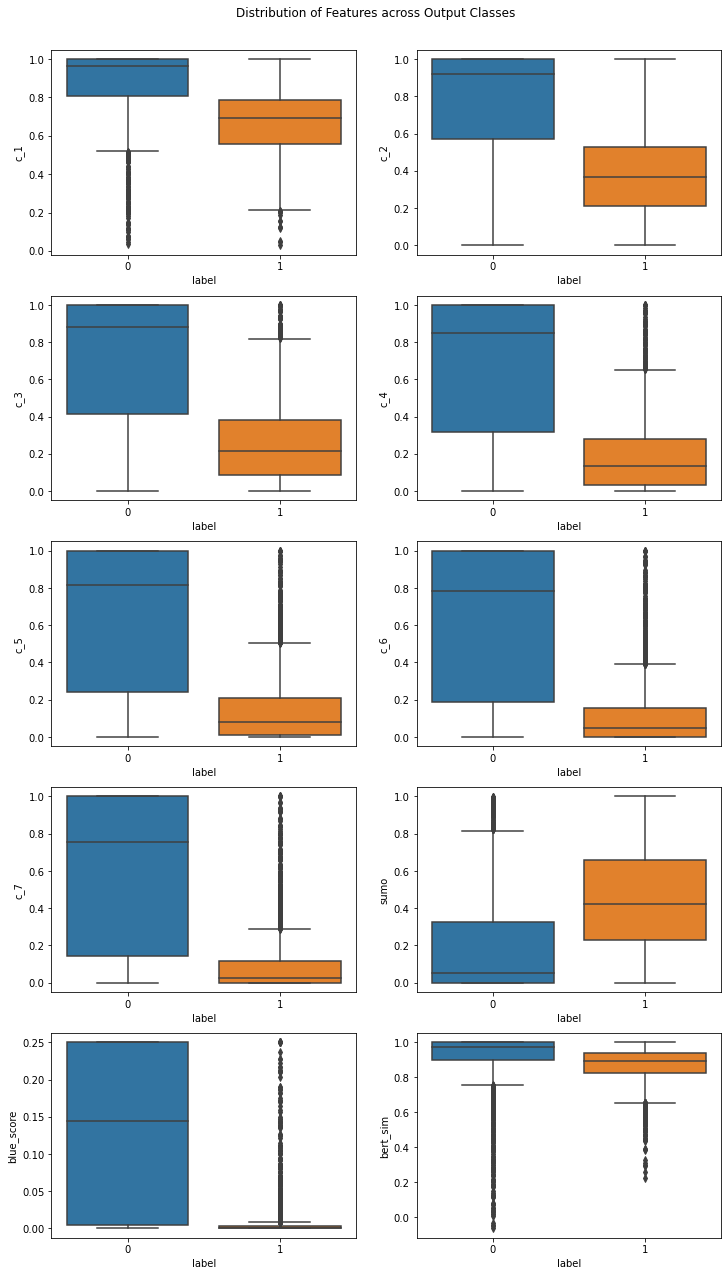

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(12, 20))
fig.suptitle('Distribution of Features across Output Classes')
y_values = features_df.columns
for i,ax in enumerate(axes.flat):
    sns.boxplot(ax=ax, x='label', y=y_values[i], data=features_df)
fig.subplots_adjust(top=0.95)
plt.show()
fig.savefig('features_boxplot.png')

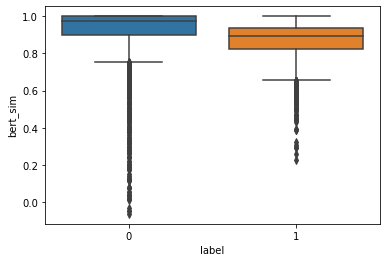

In [ ]:
fig = plt.figure()
sns.boxplot(x='label',y='bert_sim',data=features_df)
plt.show()
fig.savefig('bert_sim_boxplt.png')

In [ ]:
selected_features = ['c_1','c_6','c_7','sumo','blue_score','bert_sim']
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [ ]:
cv = StratifiedKFold(n_splits=5)

In [ ]:
lr = Pipeline([('scaler', StandardScaler()),
              ('clf', LogisticRegression(random_state=42))])
lr_cv_results = cross_validate(lr,X_train,y_train,cv=cv,scoring='roc_auc',n_jobs=-1,return_train_score=True)
np.mean(lr_cv_results['test_score']), np.mean(lr_cv_results['train_score'])

(0.9015838655333466, 0.9020904834484595)

In [ ]:
rf=RandomForestClassifier(n_estimators=1000, random_state=42)
rf_cv_results = cross_validate(rf,X_train,y_train,cv=cv,scoring='roc_auc',n_jobs=-1,return_train_score=True)
np.mean(rf_cv_results['test_score']), np.mean(rf_cv_results['train_score'])

(0.9130144567020431, 0.9995017087568476)

In [ ]:
svm = Pipeline([('scaler', StandardScaler()),
              ('clf', SVC(random_state = 42))])
svm_cv_results = cross_validate(svm,X_train,y_train,cv=cv,scoring='roc_auc',n_jobs=-1,return_train_score=True)
np.mean(svm_cv_results['test_score']), np.mean(svm_cv_results['train_score'])

(0.8913265569814337, 0.8953230109863906)

In [ ]:
ml_cv_results = pd.DataFrame({'Model':['Logistic Regression','Random Forest','Support Vector Machine'],
                             'Mean Train AUC':[np.mean(lr_cv_results['train_score']),np.mean(rf_cv_results['train_score']),
                                              np.mean(svm_cv_results['train_score'])],
                             'Mean Test AUC':[np.mean(lr_cv_results['test_score']),np.mean(rf_cv_results['test_score']),
                                             np.mean(svm_cv_results['test_score'])]})

In [ ]:
ml_cv_results.to_csv('ml_cv_results.csv',index=False)

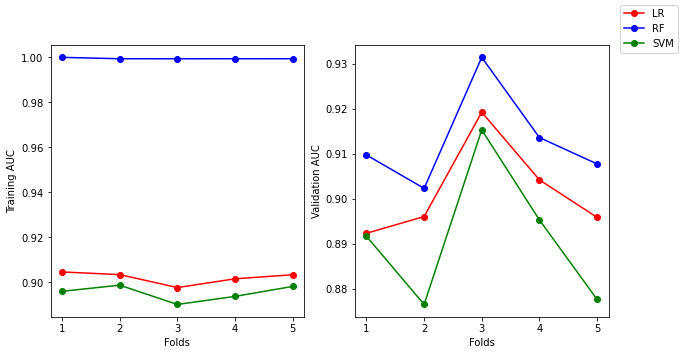

In [ ]:
#plot train scores
folds = np.arange(1,6,1, dtype=int)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(folds,lr_cv_results['train_score'],"o-", color="r", label="LR")
axes[0].plot(folds,rf_cv_results['train_score'],"o-", color="b", label="RF")
axes[0].plot(folds,svm_cv_results['train_score'],"o-", color="g", label="SVM")
axes[0].set_xlabel('Folds')
axes[0].set_ylabel('Training AUC')
axes[1].plot(folds,lr_cv_results['test_score'],"o-", color="r", label="LR")
axes[1].plot(folds,rf_cv_results['test_score'],"o-", color="b", label="RF")
axes[1].plot(folds,svm_cv_results['test_score'],"o-", color="g", label="SVM")
axes[1].set_xlabel('Folds')
axes[1].set_ylabel('Validation AUC')
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels)
plt.show()
fig.savefig('AUC_cross_validation.png')

## Learning Curve

In [ ]:
cv_lc = ShuffleSplit(n_splits=8,test_size=0.2,random_state=0)
lr_model = Pipeline([('scaler', StandardScaler()),
              ('clf', LogisticRegression(random_state=42))])
[train_sizes,train_scores,test_scores] = learning_curve(lr_model,X_train,y_train,cv=cv_lc,scoring='roc_auc',n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

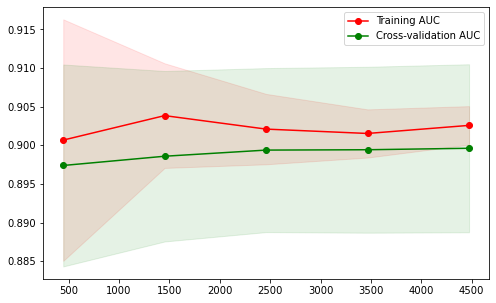

In [ ]:
fig = plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training AUC")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation AUC")
plt.fill_between(train_sizes,train_scores_mean - train_scores_std,train_scores_mean + train_scores_std,alpha=0.1,color="r")
plt.fill_between(train_sizes,test_scores_mean - test_scores_std,test_scores_mean + test_scores_std,alpha=0.1,color="g")
plt.legend()
plt.show()
fig.savefig('LR_learning_curve.png')

# Final Model

In [ ]:
lr = Pipeline([('scaler', StandardScaler()),
              ('clf', LogisticRegression(random_state=42))])
lr.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(random_state=42))])

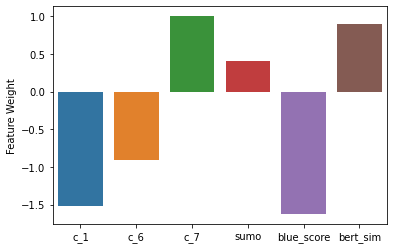

In [ ]:
# Feature Importance
fig = plt.figure()
sns.barplot(x=X_train.columns.tolist(),y=lr['clf'].coef_[0])
plt.ylabel('Feature Weight')
plt.show()
fig.savefig('LR_feature_weight.png')

In [ ]:
def classification_metrics(y_true,y_pred,y_score):
    accuracy = accuracy_score(y_true,y_pred)
    precision = precision_score(y_true,y_pred)
    auc = roc_auc_score(y_true,y_score)
    recall = recall_score(y_true,y_pred)
    mcc = matthews_corrcoef(y_true,y_pred)
    return([accuracy,auc,mcc,precision,recall])

In [ ]:
## Final model results
LR_model_metrics = pd.DataFrame({'Metrics':['Accuracy','AUC',"Mathew's Correlation Coefficient",'Precision','Recall'],
                               'Training Data':classification_metrics(y_train,lr.predict(X_train),lr.predict_proba(X_train)[:,1]),
                               'Test Data':classification_metrics(y_test,lr.predict(X_test),lr.predict_proba(X_test)[:,1])})


In [ ]:
LR_model_metrics.to_csv('LR_final_model_results.csv', index=False)

In [ ]:
X_train.shape, X_test.shape

((5592, 6), (1864, 6))

In [ ]:
rf=RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [ ]:
RF_model_metrics = pd.DataFrame({'Metrics':['Accuracy','AUC',"Mathew's Correlation Coefficient",'Precision','Recall'],
                               'Training Data':classification_metrics(y_train,rf.predict(X_train),rf.predict_proba(X_train)[:,1]),
                               'Test Data':classification_metrics(y_test,rf.predict(X_test),rf.predict_proba(X_test)[:,1])})


In [ ]:
RF_model_metrics.to_csv('RF_model_metrics.csv', index=False)

In [ ]:
svm = Pipeline([('scaler', StandardScaler()),
              ('clf', SVC(random_state = 42))])
svm.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('clf', SVC(random_state=42))])

In [ ]:
SVM_model_metrics = pd.DataFrame({'Metrics':['Accuracy','AUC',"Mathew's Correlation Coefficient",'Precision','Recall'],
                               'Training Data':classification_metrics(y_train,svm.predict(X_train),svm.decision_function(X_train)),
                               'Test Data':classification_metrics(y_test,svm.predict(X_test),svm.decision_function(X_test))})


In [ ]:
LR_model_metrics

,Metrics,Training Data,Test Data
0,Accuracy,0.818670,0.820279
1,AUC,0.902098,0.899349
2,Mathew's Correlation Coefficient,0.639527,0.643226
3,Precision,0.785634,0.786074
4,Recall,0.918033,0.921337


In [ ]:
SVM_model_metrics

,Metrics,Training Data,Test Data
0,Accuracy,0.824750,0.823498
1,AUC,0.895746,0.894870
2,Mathew's Correlation Coefficient,0.661177,0.657274
3,Precision,0.775412,0.776083
4,Recall,0.955410,0.950836


In [ ]:
SVM_model_metrics.to_csv('SVM_model_metrics.csv',index=False)

In [ ]:
feature_dataframe.describe()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,sumo,blue_score,bert_sim
count,7524.000000,7522.000000,7521.000000,7515.000000,7512.000000,7510.000000,7457.000000,7524.000000,7.859000e+03,7859.000000
mean,0.760192,0.553807,0.456637,0.400309,0.362164,0.334583,0.316144,0.317121,7.178500e-02,0.849837
std,0.202648,0.310621,0.349580,0.366478,0.375769,0.381305,0.385010,0.294224,1.027786e-01,0.214803
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.097597e-11,-0.088466
25%,0.638732,0.292683,0.150000,0.077532,0.038462,0.017094,0.001387,0.023552,1.885825e-04,0.829642
50%,0.785310,0.522727,0.371859,0.270769,0.199421,0.147111,0.110256,0.300603,3.968943e-03,0.917897
75%,0.950725,0.888889,0.835165,0.788194,0.746667,0.709895,0.681759,0.518153,1.742369e-01,0.972112
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999897,2.500000e-01,1.000000
